# Sales Prediction

Using machine learning to help organization prepare to handle dynamic market demand. Organization may infer the prediction to establish rule, plan, or strategy to further strengthen market position.

## Library Import and Configuration

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from util.dbconn import DbConn

In [2]:
WAREHOUSE_CONN = {
    'user': 'postgres',
    'password': 'qshOke46RvOg0',
    'host': '10.128.0.2',
    'port': '8084',
    'dbname': 'postgres'
}

In [3]:
postgres_conn = DbConn(WAREHOUSE_CONN).get_conn()

## Data Overview

In [4]:
sql = """SELECT 
	dd."year",
	dd."month",
	dd.week_num_in_year,
	dd."date",
	count(DISTINCT fo.order_legacy_id) as count_order
FROM 
	warehouse.fact_order fo
LEFT JOIN warehouse.date_dim dd ON
	fo.order_date = dd.date_id
GROUP BY 1,2,3,4;
"""

In [5]:
df = pd.read_sql(sql=sql, con=postgres_conn)

display(df.info())
display(df.describe())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   year              634 non-null    int64
 1   month             634 non-null    int64
 2   week_num_in_year  634 non-null    int64
 3   date              634 non-null    int64
 4   count_order       634 non-null    int64
dtypes: int64(5)
memory usage: 24.9 KB


None

,year,month,week_num_in_year,date,count_order
count,634.000000,634.000000,634.000000,634.000000,634.000000
mean,2017.383281,5.938486,24.501577,15.597792,156.847003
std,0.533051,3.214452,14.111411,8.768610,94.224817
min,2016.000000,1.000000,1.000000,1.000000,1.000000
25%,2017.000000,3.000000,13.000000,8.000000,96.000000
50%,2017.000000,6.000000,24.000000,15.500000,148.000000
75%,2018.000000,8.000000,35.000000,23.000000,215.750000
max,2018.000000,12.000000,53.000000,31.000000,1176.000000


,year,month,week_num_in_year,date,count_order
0,2016,9,36,4,1
1,2016,9,37,5,1
2,2016,9,38,13,1
3,2016,9,38,15,1
4,2016,10,40,2,1


### Check Null Values

In [6]:
df.isnull().sum()

year                0
month               0
week_num_in_year    0
date                0
count_order         0
dtype: int64

## Exploratory Data Analysis

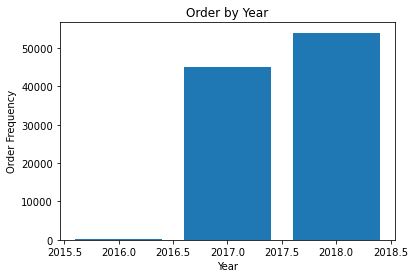

,year,count_order
0,2016,329
1,2017,45101
2,2018,54011


In [7]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['year', 'count_order']].groupby('year', as_index=False).sum()

ax.bar(_df_temp['year'], _df_temp['count_order'])
ax.set_title('Order by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

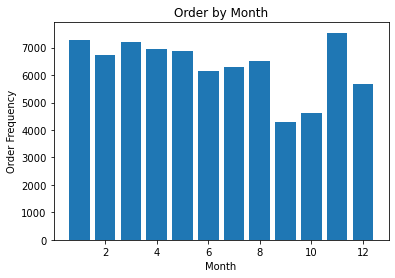

,year,month,count_order
0,2016,9,4
1,2016,10,324
2,2016,12,1
3,2017,1,800
4,2017,2,1780
5,2017,3,2682
6,2017,4,2404
7,2017,5,3700
8,2017,6,3245
9,2017,7,4026


In [8]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['year', 'month', 'count_order']] \
            .groupby(by=['year', 'month'], as_index=False) \
            .sum()

ax.bar(_df_temp['month'], _df_temp['count_order'])
ax.set_title('Order by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

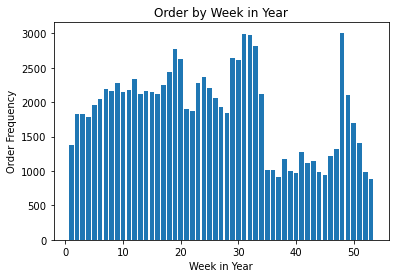

,week_num_in_year,count_order
0,1,1383
1,2,1831
2,3,1830
3,4,1788
4,5,1952
5,6,2051
6,7,2188
7,8,2167
8,9,2282
9,10,2140


In [9]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['week_num_in_year', 'count_order']] \
            .groupby(by='week_num_in_year', as_index=False) \
            .sum()

ax.bar(_df_temp['week_num_in_year'], _df_temp['count_order'])
ax.set_title('Order by Week in Year')
ax.set_xlabel('Week in Year')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

In [10]:
model_df = df.copy()

## Data Preprocessing

In [11]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
normalizer = Normalizer(norm='l2')
standardize = StandardScaler()

## Utility Functions

In [12]:
def _tscv(X, pipe):
    tscv = TimeSeriesSplit()

    errors = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        errors.append(mse)
    
    print(errors)
    print(sum(errors)/len(errors))

In [13]:
def shift(data, n_in=1, n_out=1, dropna=True):
    """
    Arguments:
        data: Sequence of observations as DataFrame or Numpy Array.
        n_in: Number of lag observations as input.
        n_out: Number of observations as output.
        dropna: Boolean whether to drop rows with NaN values.
    Returns:
        df: Pandas DataFrame
    """
    
    try:
        var = range(0, data.shape[1]) if isinstance(data, np.ndarray) else \
                data.columns if isinstance(data, pd.DataFrame) else None
    except IndexError as e:
        var = range(0, 1)
    
    if var is None:
        raise Exception('Expected pandas.DataFrame or numpy.ndarray got {}'.format(type(data)))
    
    df = pd.DataFrame(data)
    cols, names = [], []
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{n}(t-{i})'.format(n=v, i=i)) for v in var]
    
    for i in range(0, n_out):
        cols.append(df.shift(i))
        if i == 0:
            names += [('{n}(t)'.format(n=v)) for v in var]
        else:
            names += [('{n}(t+{i})'.format(n=v, i=i)) for v in var]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropna:
        agg.dropna(inplace=True)
    
    return agg

In [14]:
def evaluate(y_actual, y_pred):
    med_ae = median_absolute_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mean_squared_error(y_actual, y_pred, squared=False)
    
    return {
        'Median Absolute Error': med_ae,
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
    }

In [15]:
def _tscv_eval(X, pipe):
    tscv = TimeSeriesSplit()

    errors = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        error = evaluate(y_test, y_pred)
        errors.append(error)
    
    print(json.dumps(errors, indent=4))

## Naive Model

In [16]:
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error

In [17]:
y = model_df.loc[:, 'count_order']
# Set to predict the mean
y_pred = [y.mean() for i in range(0, len(y))]

mse = mean_squared_error(y, y_pred)
print(mse)

8864.3125541104


In [18]:
y = model_df.loc[:, 'count_order']
# Set to predict the mean
y_pred = [y.mean() for i in range(0, len(y))]

print(json.dumps(evaluate(y, y_pred), indent=4))

{
    "Median Absolute Error": 59.84700315457414,
    "Mean Absolute Error": 70.68741354775149,
    "Mean Squared Error": 8864.3125541104,
    "Root Mean Squared Error": 94.15047824684908
}


## Feature Engineering

In [19]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

In [20]:
shifted = shift(y, 2, 1, dropna=False)

In [21]:
shifted.loc[:, ['0(t-2)','0(t-1)']].to_numpy()

array([[nan, nan],
       [nan,  1.],
       [ 1.,  1.],
       ...,
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [22]:
_X = np.concatenate((X, shifted), axis=1)

_X = pd.DataFrame(_X)
_X = _X.dropna()
_X = _X.to_numpy()

_y = y[2:]

## MLP Regressor

In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit

In [24]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [25]:
from sklearn.metrics import make_scorer

In [26]:
# mse_scorer = make_scorer(mean_squared_error)

# pipe = Pipeline([
#         ('scale', StandardScaler()),
#         ('mlp', MLPRegressor(max_iter=1000))])

# param_grid = dict(mlp__hidden_layer_sizes=[(100,),(100,30),(100,30,10)],
#                   mlp__activation=['identity', 'relu', 'logistic'],
#                   mlp__learning_rate_init=[0.001,0.003,0.005,0.01,0.05])

# grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
#                     scoring=mse_scorer, n_jobs=1, verbose=1)
# grid.fit(X, y)

In [27]:
# print(grid.best_score_)
# print(grid.best_estimator_)

In [28]:
## DO NOT DELETE
# mlpr = MLPRegressor(
#             hidden_layer_sizes=(100,30),
#             activation='relu',
#             solver='lbfgs',
#             learning_rate='constant',
#             learning_rate_init=0.001,
#             max_iter=1000)

### Default Parameter

In [29]:
mlpr = MLPRegressor(max_iter=1000)
# model = make_pipeline(normalizer, mlpr)
model = make_pipeline(standardize, mlpr)

_tscv(X, model)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[772.1629574664092, 1496.1711984062458, 31720.64268829311, 4619.564693658943, 14743.482770176699]
10670.40486160028


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Final Model

In [30]:
mlpr = MLPRegressor(max_iter=1000, activation='identity',
                   solver='sgd', learning_rate='constant',
                   tol=0.005)

pipe = make_pipeline(standardize, mlpr)

_tscv(X, pipe)

[1746.5696388968117, 1505.2625780085796, 15799.468206873238, 4191.088991176569, 25356.5490660438]
9719.7876961998


In [31]:
mlpr = MLPRegressor(max_iter=1000, activation='identity',
                   solver='sgd', learning_rate='constant',
                   tol=0.005)

pipe = make_pipeline(standardize, mlpr)

_tscv_eval(X, pipe)

[
    {
        "Median Absolute Error": 27.142517446008398,
        "Mean Absolute Error": 33.74645318479217,
        "Mean Squared Error": 1723.265622538654,
        "Root Mean Squared Error": 41.51223461268562
    },
    {
        "Median Absolute Error": 23.40852662066689,
        "Mean Absolute Error": 24.984568591442383,
        "Mean Squared Error": 973.1041150693864,
        "Root Mean Squared Error": 31.194616764265376
    },
    {
        "Median Absolute Error": 44.71859251655627,
        "Mean Absolute Error": 66.12875540070046,
        "Mean Squared Error": 15563.068053241093,
        "Root Mean Squared Error": 124.75202624903972
    },
    {
        "Median Absolute Error": 43.10847250573585,
        "Mean Absolute Error": 51.95816625241812,
        "Mean Squared Error": 4219.487066921283,
        "Root Mean Squared Error": 64.95757897983331
    },
    {
        "Median Absolute Error": 88.6775531507468,
        "Mean Absolute Error": 118.43730853988237,
        "Mean Squ

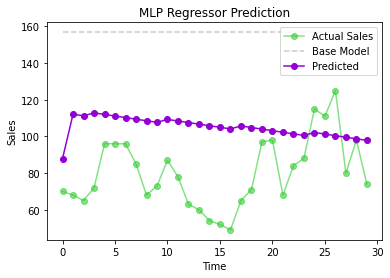

In [32]:
mlpr = MLPRegressor(max_iter=1000, activation='identity',
                   solver='sgd', learning_rate='constant',
                   tol=0.005)

pipe = make_pipeline(standardize, mlpr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual[100:130], label='Actual Sales', color='limegreen', alpha=0.6, marker='o')
ax.plot(y_base[100:130], label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred[100:130], label='Predicted', color='darkviolet', marker='o')

ax.set_title('MLP Regressor Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

## Support Vector Regression

In [33]:
from sklearn.svm import LinearSVR

In [34]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [35]:
# mse_scorer = make_scorer(mean_squared_error)

# pipe = Pipeline([
#         ('scale', StandardScaler()),
#         ('svr', LinearSVR())])

# param_grid = dict(svr__tol=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
#                   svr__max_iter=[1000,2000,5000],
#                   svr__C=[1, 1.5, 2, 2.5, 3, 3.5])

# grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
#                     scoring=mse_scorer, n_jobs=1, verbose=1)
# grid.fit(X, y)

In [36]:
# print(grid.best_score_)
# print(grid.best_estimator_)

### Default Parameter

In [37]:
svr = LinearSVR()

pipe = make_pipeline(standardize, svr)

_tscv(X, pipe)

[4182.639734458266, 966.5009078931267, 18084.497271873144, 4007.2094658348406, 15519.383620347138]
8552.046200081302


### Final Model

In [38]:
final_svr = LinearSVR(C=2, max_iter=2000, tol=0.05)

pipe = make_pipeline(standardize, final_svr)

_tscv(X, pipe)

[2106.497345803477, 900.0481714557163, 16937.994199367306, 3869.116077687136, 19166.009043505845]
8595.932967563896


In [39]:
final_svr = LinearSVR(C=2, max_iter=2000, tol=0.05)

pipe = make_pipeline(standardize, final_svr)

_tscv_eval(X, pipe)

[
    {
        "Median Absolute Error": 38.11914787949652,
        "Mean Absolute Error": 40.52178089344402,
        "Mean Squared Error": 2305.21980028731,
        "Root Mean Squared Error": 48.01270457167884
    },
    {
        "Median Absolute Error": 21.800805730693924,
        "Mean Absolute Error": 24.212061447024023,
        "Mean Squared Error": 900.874809346523,
        "Root Mean Squared Error": 30.014576614480553
    },
    {
        "Median Absolute Error": 43.25198244295831,
        "Mean Absolute Error": 67.07105208668321,
        "Mean Squared Error": 16069.450053131319,
        "Root Mean Squared Error": 126.76533458769917
    },
    {
        "Median Absolute Error": 45.79175892432403,
        "Mean Absolute Error": 53.03529566835922,
        "Mean Squared Error": 4086.343375231477,
        "Root Mean Squared Error": 63.92451310124682
    },
    {
        "Median Absolute Error": 74.64280011913695,
        "Mean Absolute Error": 104.89410408184636,
        "Mean Squa

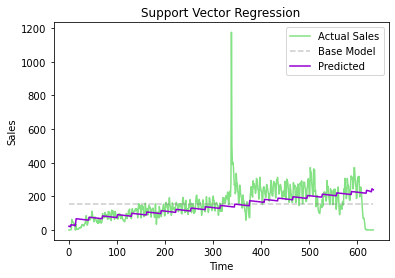

In [49]:
final_svr = LinearSVR(C=2, max_iter=2000, tol=0.05)

pipe = make_pipeline(standardize, final_svr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet')

ax.set_title('Support Vector Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

## SGD Regressor

In [45]:
from sklearn.linear_model import SGDRegressor

In [46]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [43]:
# mse_scorer = make_scorer(mean_squared_error)

# pipe = Pipeline([
#         ('scale', StandardScaler()),
#         ('sgdr', SGDRegressor())])

# param_grid = dict(sgdr__loss=['squared_loss', 'huber'],
#                   sgdr__epsilon=[0.1,0.3,0.5],
#                   sgdr__learning_rate=['constant', 'invscaling', 'adaptive'],
#                   sgdr__eta0=[0.01,0.03,0.05],
#                   sgdr__max_iter=[5000,10000],
#                   sgdr__alpha=[0.0001,0.0005,0.001])

# grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
#                     scoring=mse_scorer, n_jobs=1, verbose=1)
# grid.fit(X, y)

In [44]:
# print(grid.best_score_)
# print(grid.best_estimator_)

### Default Parameter & Final Model

In [45]:
sgdr = SGDRegressor()

pipe = make_pipeline(standardize, sgdr)

_tscv(X, pipe)

[1081.3729138264357, 1313.6989366698067, 15786.07970618961, 5042.626581624553, 24112.23413850876]
9467.202455363833


In [47]:
sgdr = SGDRegressor()

pipe = make_pipeline(standardize, sgdr)

_tscv_eval(X, pipe)

[
    {
        "Median Absolute Error": 23.429251749321352,
        "Mean Absolute Error": 27.79063664419761,
        "Mean Squared Error": 1224.4910081643181,
        "Root Mean Squared Error": 34.99272793259077
    },
    {
        "Median Absolute Error": 23.97245185889554,
        "Mean Absolute Error": 28.989763460191526,
        "Mean Squared Error": 1280.5527438683089,
        "Root Mean Squared Error": 35.78481163661909
    },
    {
        "Median Absolute Error": 46.69644275135556,
        "Mean Absolute Error": 66.9489316678313,
        "Mean Squared Error": 15766.532259560694,
        "Root Mean Squared Error": 125.56485280348436
    },
    {
        "Median Absolute Error": 45.608365023035674,
        "Mean Absolute Error": 55.11983134680091,
        "Mean Squared Error": 5036.534926280754,
        "Root Mean Squared Error": 70.96854885285984
    },
    {
        "Median Absolute Error": 88.831792261965,
        "Mean Absolute Error": 116.66319439101524,
        "Mean Squ

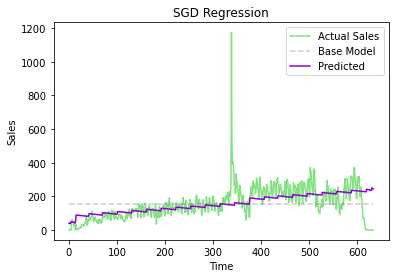

In [48]:
sgdr = SGDRegressor()

pipe = make_pipeline(standardize, sgdr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet')

ax.set_title('SGD Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

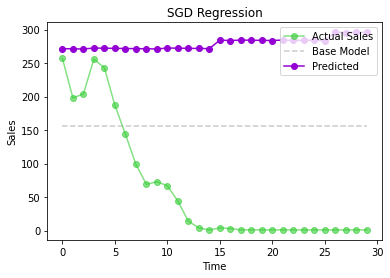

In [48]:
sgdr = SGDRegressor()

pipe = make_pipeline(standardize, sgdr)

model = pipe.fit(X[:len(X)-30], y[:len(y)-30])

y_actual = y[len(y)-30:]
y_base = [y.mean() for i in range(0, 30)]
y_pred = model.predict(X[len(X)-30:])

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6, marker='o')
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet', marker='o')

ax.set_title('SGD Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

## Random Forest Regression

In [50]:
from sklearn.ensemble import RandomForestRegressor

In [51]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

In [54]:
rfr = RandomForestRegressor()

pipe = make_pipeline(standardize, rfr)

_tscv_eval(X, pipe)

[
    {
        "Median Absolute Error": 40.260000000000005,
        "Mean Absolute Error": 45.44190476190476,
        "Mean Squared Error": 3392.3187638095233,
        "Root Mean Squared Error": 58.24361564849424
    },
    {
        "Median Absolute Error": 76.57,
        "Mean Absolute Error": 74.40780952380952,
        "Mean Squared Error": 7168.981660952381,
        "Root Mean Squared Error": 84.66983914566262
    },
    {
        "Median Absolute Error": 139.22,
        "Mean Absolute Error": 140.02580952380953,
        "Mean Squared Error": 34650.028183809525,
        "Root Mean Squared Error": 186.14518039371723
    },
    {
        "Median Absolute Error": 45.53,
        "Mean Absolute Error": 50.92171428571428,
        "Mean Squared Error": 3806.789514285714,
        "Root Mean Squared Error": 61.699185685758565
    },
    {
        "Median Absolute Error": 68.91999999999999,
        "Mean Absolute Error": 85.2384761904762,
        "Mean Squared Error": 10460.684805714285,
  

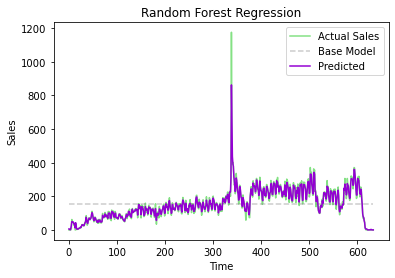

In [53]:
rfr = RandomForestRegressor()

pipe = make_pipeline(standardize, rfr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet')

ax.set_title('Random Forest Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()